# Module 1 Homework

In [1]:
import math
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error 

In [30]:
# Function that does everythin above: Can be used for validation dataset

def process_dataset(path):
    df = pd.read_parquet(path)
    df = df[df.trip_type == 2]
    
    # Calculate duration
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    # Convert datetime to minutes
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60.0)

    #categorical = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df[categorical] = df[categorical].astype(str)

    
    return df

In [31]:
df_train = process_dataset('data/green_tripdata_2021-01.parquet')
df_val = process_dataset('data/green_tripdata_2021-02.parquet')

In [54]:
df_train['PO_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PO_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

### Train model

Training Pipeline

Train RMSE: 3.4113647507698737
Val RMSE: 8.522974614284754


/tmp/ipykernel_23534/890517536.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='predictions')
/tmp/ipykernel_23534/890517536.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='training')


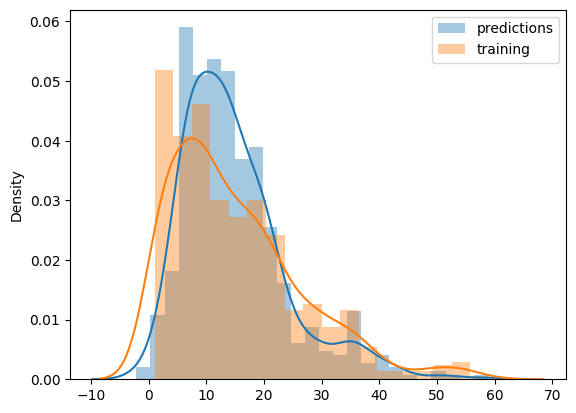

In [68]:
#categorical = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']
categorical = ['PO_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()  # Turns a dictionary into vector

train_dicts= df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

linear_model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(f'Train RMSE: {math.sqrt(mean_squared_error(y_train, y_pred))}')

y_pred = model.predict(X_val)
print(f'Val RMSE: {math.sqrt(mean_squared_error(y_val, y_pred))}')


# Visualize predictions
sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='training')
plt.legend()

 Model is wrong on average by 4.8 minutes, on validation its nealy 8 minutes.

Try Lasso

In [65]:
# Use Lasso regression: Linear regression with regularization

model = Lasso(alpha=0.0001)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

math.sqrt(mean_squared_error(y_train, y_pred))

3.4113647507698737

Worse than Linear Regression

In [60]:
# Use Lasso regression: Linear regression with regularization

model = Ridge(alpha=0.001)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

math.sqrt(mean_squared_error(y_train, y_pred))

3.4231256303513597

Riege not better as well.

In [69]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linear_model ), f_out)